# Imports

In [1]:
import gc
import math
from time import time_ns
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import numba as nb
from numba import cuda  # must be explicitly imported
from tqdm import tqdm

if False:  # numba unhappy when used with target=cuda
    sin = np.sin
    cos = np.cos
else:
    sin = math.sin
    cos = math.cos

COMPLEXITY = 2 ** 11

# Base implementation of the test

Pure Python plus `numpy`, intentionally iterative approach.

In [2]:
def base_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

def base(d: np.ndarray) -> np.ndarray:
    r = np.zeros(d.shape, dtype = d.dtype)
    for idx in range(d.shape[0]):
        r[idx] = base_dummy(d[idx])
    return r

# Using `numba.vectorized`, target `cpu`

In [3]:
@nb.njit
def vectorized_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.vectorize
def vectorized(d: float) -> float:
    return vectorized_dummy(d)

# Using `numba.guvectorized`, target `cpu`

In [4]:
@nb.njit('f8(f8)')
def guvectorized_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.guvectorize('void(f8[:],f8[:])', '(n)->(n)')
def guvectorized(d: float, r: float):
    for idx in range(d.shape[0]):
        r[idx] = guvectorized_dummy(d[idx])

# Using `numba.vectorized`, target `parallel`

In [5]:
@nb.njit('f8(f8)')
def vectorized_parallel_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.vectorize('f8(f8)', target = 'parallel')
def vectorized_parallel(d: float) -> float:
    return vectorized_parallel_dummy(d)

# Using `numba.guvectorized`, target `parallel`

In [6]:
@nb.njit('f8(f8)')
def guvectorized_parallel_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.guvectorize('void(f8[:],f8[:])', '(n)->(n)', target = 'parallel')
def guvectorized_parallel(d: float, r: float):
    for idx in nb.prange(d.shape[0]):
        r[idx] = guvectorized_parallel_dummy(d[idx])

# Using `numba.vectorized`, target `cuda`

In [7]:
@cuda.jit('f8(f8)', device = True, inline = True)
def vectorized_cuda_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.vectorize('f8(f8)', target = 'cuda')
def vectorized_cuda(d: float) -> float:
    return vectorized_cuda_dummy(d)

# Using `numba.guvectorized`, target `cuda`

In [8]:
@cuda.jit('f8(f8)', device = True, inline = True)
def guvectorized_cuda_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.guvectorize('void(f8[:],f8[:])', '(n)->(n)', target = 'cuda')
def guvectorized_cuda(d: float, r: float):
    for idx in nb.prange(d.shape[0]):
        r[idx] = guvectorized_cuda_dummy(d[idx])

# Verification of results of all functions against base implementation

In [9]:
funcs = [
    base,
    vectorized,
    vectorized_parallel,
    vectorized_cuda,
    guvectorized,
    guvectorized_parallel,
    guvectorized_cuda,
]

In [10]:
def test_all(size = 100):
    
    data = np.random.random(size) * 128
    res_base = funcs[0](data)
    
    for func in funcs[1:]:
        res = func(data)
        assert np.allclose(res_base, res)
        
test_all()

/home/ernst/Desktop/PROJEKTE/prj.TST2/github.poliastro/env310/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


# Benchmark

In [11]:
def _name(func):
    try:
        return func.__name__
    except AttributeError:  # numba#8272
        try:
            return list(func.functions.values())[0][1].py_func.__name__[13:]
        except AttributeError:  # TODO
            return list(func.kernelmap.values())[0][1].py_func.__name__[9:]

def benchmark(start = 4, stop = 16, reps = 2):  # 16 or 23 ... 13 should do
    sizes = (2 ** np.arange(start, stop + 0.5, 0.5)).astype('i8')
    results = {_name(func): [] for func in funcs[1:]}
    gc.disable()
    for size in tqdm(sizes):
        data = np.arange(0, size, 1, dtype = 'f8')
        for func in funcs[1:]:  # exclude pure python
            runtimes = []
            for rep in range(reps):
                gc.collect()
                start = time_ns()
                _ = func(data)
                runtime = time_ns() - start
                runtimes.append(runtime)
            results[_name(func)].append(min(runtimes) * 1e-9)
    gc.enable()
    return sizes, results

s, r = benchmark()

 44%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                 | 11/25 [00:09<00:17,  1.22s/it]/home/ernst/Desktop/PROJEKTE/prj.TST2/github.poliastro/env310/lib/python3.10/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                      

# Benchmark Analysis

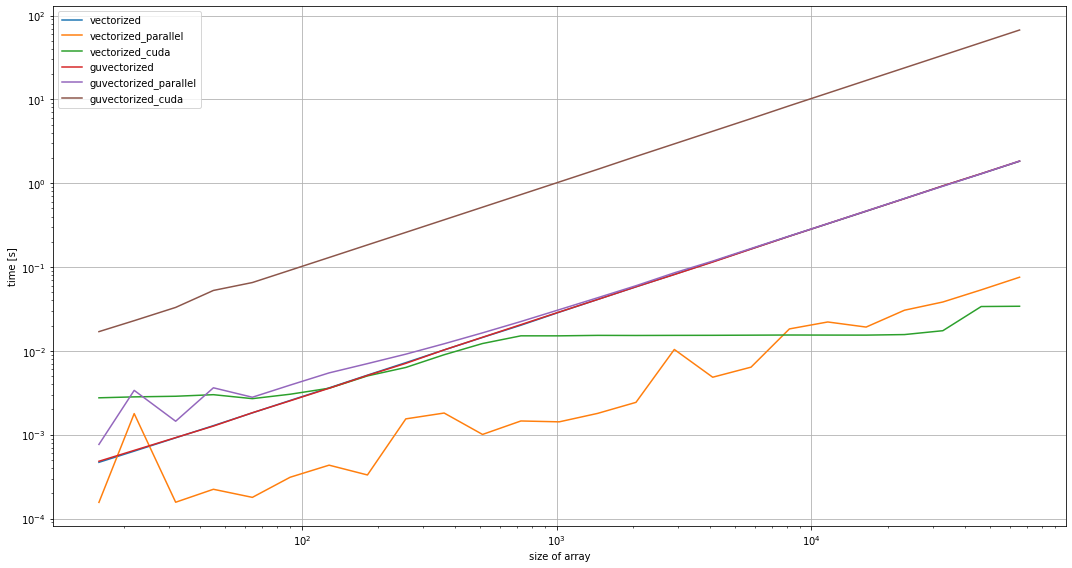

In [12]:
def plot_all(sizes, results):
    fig, ax = plt.subplots(figsize = (15, 8))
    for name, values in results.items():
        ax.loglog(sizes, values, label = name)
    ax.legend()
    ax.set_xlabel('size of array')
    ax.set_ylabel('time [s]')
    ax.grid()
    fig.tight_layout()
    fig.savefig('plot_all.jpg')

plot_all(s, r)

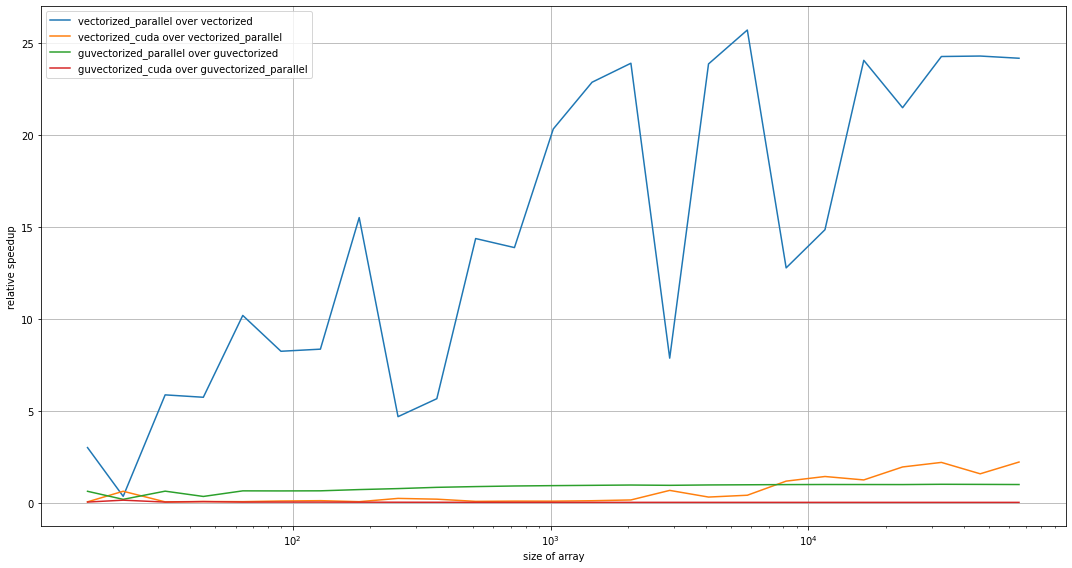

In [13]:
def plot_relative_speedup(sizes, results, pairs):
    fig, ax = plt.subplots(figsize = (15, 8))
    for base, faster in pairs:
        ax.semilogx(
            sizes,
            np.array(r[base]) / np.array(r[faster]),
            label = f'{faster:s} over {base:}',
        )
    ax.legend()
    ax.set_xlabel('size of array')
    ax.set_ylabel('relative speedup')
    ax.grid()
    fig.tight_layout()
    fig.savefig('plot_relative_speedup.jpg')

plot_relative_speedup(s, r, pairs = [
    ('vectorized', 'vectorized_parallel'),
    ('vectorized_parallel', 'vectorized_cuda'),
    ('guvectorized', 'guvectorized_parallel'),
    ('guvectorized_parallel', 'guvectorized_cuda'),
])

# Benchmark Raw Results

In [14]:
s

array([   16,    22,    32,    45,    64,    90,   128,   181,   256,
         362,   512,   724,  1024,  1448,  2048,  2896,  4096,  5792,
        8192, 11585, 16384, 23170, 32768, 46340, 65536])

In [15]:
pprint(r)

{'guvectorized': [0.000481822,
                  0.000649533,
                  0.000922184,
                  0.001266826,
                  0.0018272890000000002,
                  0.002535821,
                  0.003578837,
                  0.005090454,
                  0.007092293,
                  0.010264958000000001,
                  0.014521358000000002,
                  0.020544026,
                  0.029070047,
                  0.040987261000000004,
                  0.058053820000000006,
                  0.081342579,
                  0.114645254,
                  0.163599343,
                  0.232865335,
                  0.328985491,
                  0.4642121,
                  0.653381867,
                  0.9288389140000001,
                  1.3001342200000001,
                  1.8351700020000001],
 'guvectorized_cuda': [0.016954919000000002,
                       0.022913187,
                       0.032971774,
                       0.052537395,
      